# 5. Exploratory Data Analysis

## 5.1 Import Libraries

In [1]:
import random, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

## 5.2 Load Sorted Data

Count all raw image files by aggregating class folders file counts

In [3]:
def get_image_paths(data_dir):
    image_paths = []
    for root, dirs, files in os.walk(data_dir):       
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_image_paths("../02. Datasets/Images_Raw")
print(len(image_paths))
image_paths[0:2]

96820


['../02. Datasets/Images_Raw\\Acantholysis\\aad.org_en_1.jpg',
 '../02. Datasets/Images_Raw\\Acantholysis\\aad.org_en_3.jpg']

## 5.3 EDA Pipeline

### 5.3.1 Calculate Total URLs acquired for the Dataset

Count all URLs acquired in Dataset_URLs.json file

In [4]:
# Import static .json file
with open('../02. Datasets/Dataset_URLs.json', 'r', encoding='utf-8') as file:
    search_list_data = json.load(file)

def process_json_data(data):
    results = []
    for item in data:
        label = item["label"]
        total_urls = 0
        for site in item["imageURLs"]["site"].values():
            if "lang" in site:
                total_urls += sum(len(urls) for urls in site["lang"].values())
            else:
                total_urls += len(site) 
        results.append({"Class": label, "Total_URLs": total_urls})
    df = pd.DataFrame(results).sort_values(by='Class', ascending=True) 
    return df

df = process_json_data(search_list_data)
print(f"Total URLs: {'{:,}'.format(df['Total_URLs'].sum())} unique URLs found")
df

Total URLs: 143,391 unique URLs found


,Class,Total_URLs
220,Acantholysis,384
105,Acanthosis Nigricans,1314
1,Acne Conglobata,987
0,Acne Keloid,993
19,Acrodermatitis,594
...,...,...
111,Vitiligo,1527
236,"Xanthogranuloma, Juvenile",749
102,Xeroderma Pigmentosum,1027
183,Yaws,644


### 5.3.2 Visualize Class Distribution of Dataset

In [6]:
df = pd.DataFrame(image_paths, columns=['image_path'])
df['class'] = df['image_path'].apply(lambda x: x.split('\\')[1])

# Show raw class distribution
pd.set_option('display.max_rows', None)
print(df['class'].value_counts())

class
Dermatitis, Atopic                                         1515
Pityriasis Rosea                                           1457
Dermatitis, Seborrheic                                     1374
Keratosis, Seborrheic                                      1317
Vitiligo                                                   1264
Tinea Pedis                                                1233
Alopecia Areata                                            1156
Sunburn                                                    1115
Port-Wine Stain                                            1109
Blister                                                    1073
Tinea cruris                                               1069
Scabies                                                    1048
Acanthosis Nigricans                                       1042
Onychomycosis                                              1004
Acne Conglobata                                             978
Impetigo                          

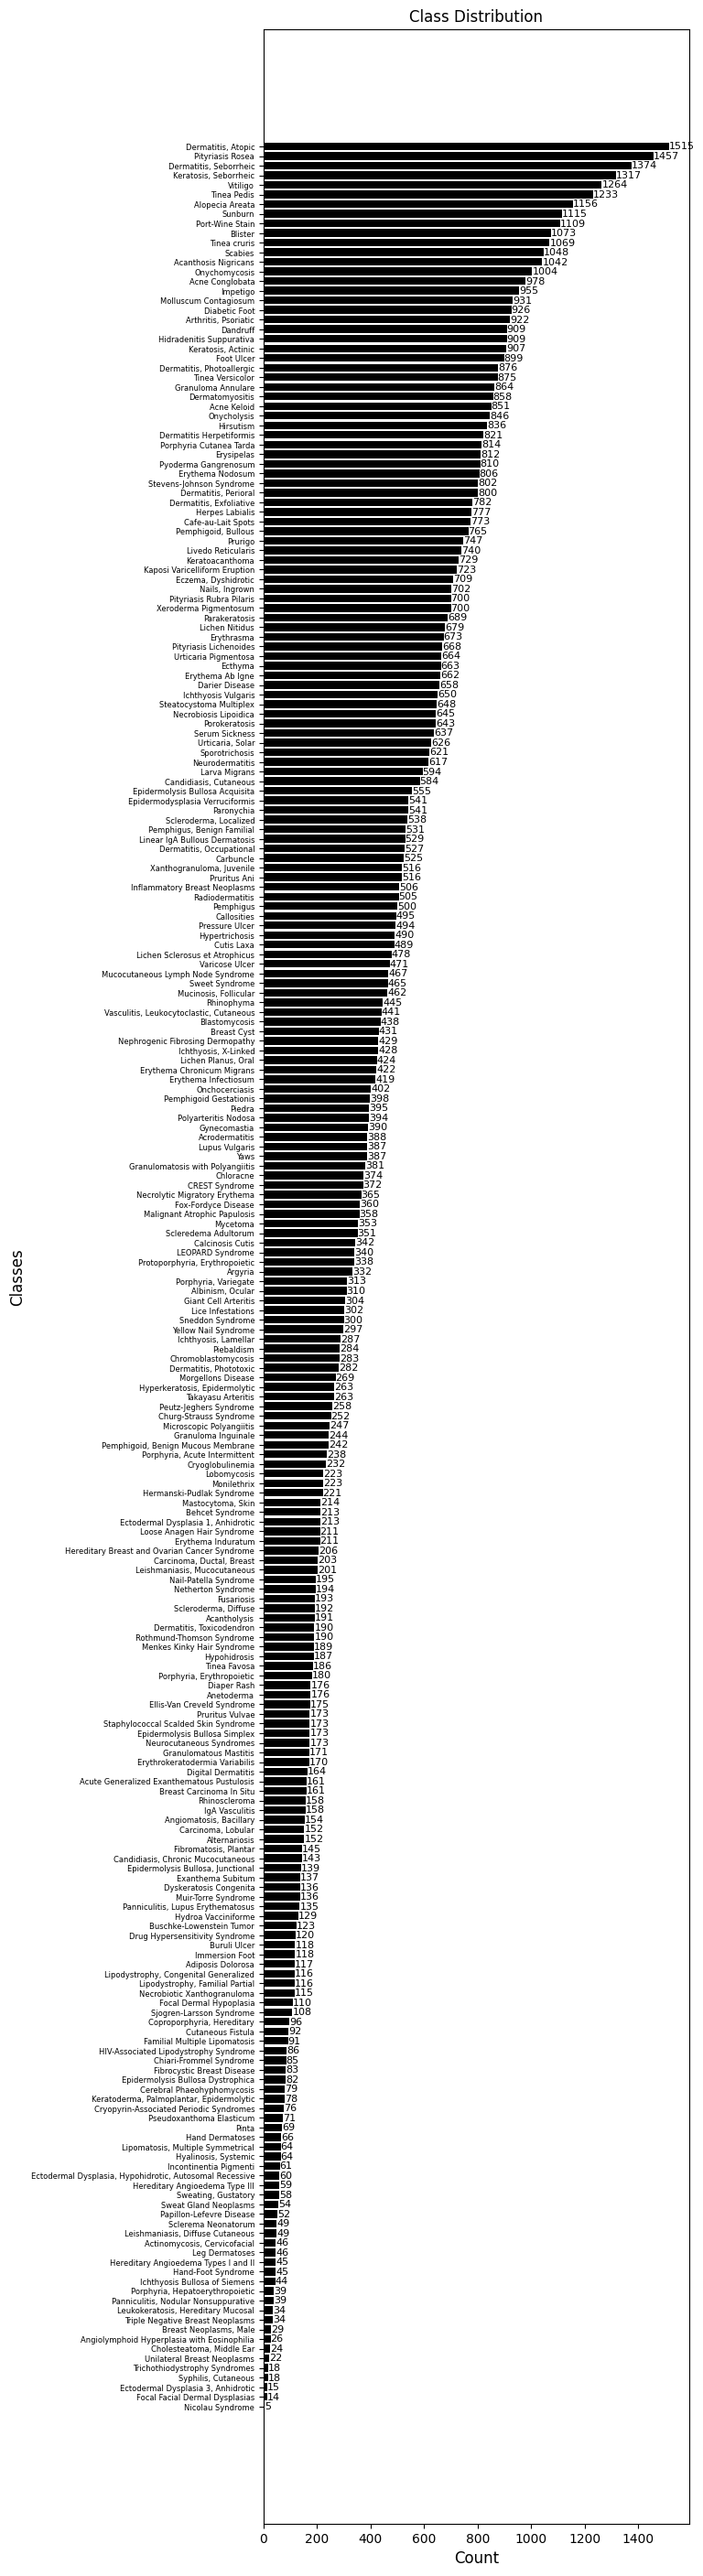

In [7]:
def plot_class_distribution(df):
    class_counts = df['class'].value_counts()
    height_per_class = 0.15
    fig_height = len(class_counts) * height_per_class
    plt.figure(figsize=(6, fig_height)) 
    colors = ["black"] * len(class_counts)
    bars = plt.barh(class_counts.index, class_counts.values, color=colors)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Classes', fontsize=12)
    plt.title('Class Distribution', fontsize=12)
    plt.gca().tick_params(axis='y', labelsize=6)
    plt.gca().invert_yaxis()
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                 f'{int(bar.get_width())}', va='center', ha='left', fontsize=8)
    plt.show()

plot_class_distribution(df)

### 5.3.3 Visualize Distribution of Dataset Files

In [8]:
def count_files_in_folders(target_path):
    counts = defaultdict(lambda: {'classCount': 0, 'junkCount': 0, 'totalCount': 0, 'sources': defaultdict(int)})

    for root, dirs, files in os.walk(target_path):
        if root.count(os.sep) == target_path.count(os.sep) + 1:
            class_name = os.path.basename(root)
            counts[class_name]

    for root, dirs, files in os.walk(target_path):
        junk_folderName = 'junk'
        if root.count(os.sep) == target_path.count(os.sep) + 1 or junk_folderName in root:
            class_name = os.path.basename(root) if junk_folderName not in root else os.path.basename(os.path.dirname(root))
            
            # Iterate all files in current folder
            for file in files:
                # Process .jpg files only
                if file.endswith('.jpg'):
                    # Increment 'junkCount' file count
                    if junk_folderName in root:
                        counts[class_name]['junkCount'] += 1
                    # Increment 'classCount' file count 
                    else:
                        counts[class_name]['classCount'] += 1
                    source = file.split('_')[0]
                    # Increment file count of URL source 
                    counts[class_name]['sources'][source] += 1

    # Calculate total count of images(class + junk) for each class
    for class_name, count in counts.items():
        count['totalCount'] = count['classCount'] + count['junkCount']
    data = []
    
    for class_name, count in counts.items():
        row = [class_name, count['classCount'], count['junkCount'], count['totalCount']]
        row.extend(count['sources'].values())
        data.append(row)

    headers = ['className', 'classCount', 'junkCount', 'totalCount']
    URL_source_headers = sorted(set(source for count in counts.values() for source in count['sources']))
    headers.extend(URL_source_headers)
    
    try:
        processed_data = []
        for row in data:
            row_dict = dict(zip(headers, row))
    
            for header in headers:
                row_dict.setdefault(header, 0)
        
            processed_row = [row_dict[header] for header in headers]
            processed_data.append(processed_row)
        
        df = pd.DataFrame(processed_data, columns=headers)
    except ValueError as e:
        if len(headers) != len(data[0]):
            print("Error: The number of headers does not match the number of columns in the data.")
            print(f"Number of headers: {len(headers)}")
            print(f"Number of columns in data: {len(data[0])}")
            print("Headers:", headers)
            print("First row of data:", data[0])
        else:
            print("An error occurred:", e)

    # Fill missing NaN values with 0
    df.fillna(0, inplace=True)
    
    for col in URL_source_headers:
        df[col] = df[col].astype(int)

    return df

pd.set_option('display.max_rows', None)
df = count_files_in_folders("../02. Datasets/Images_Cleaned")
df

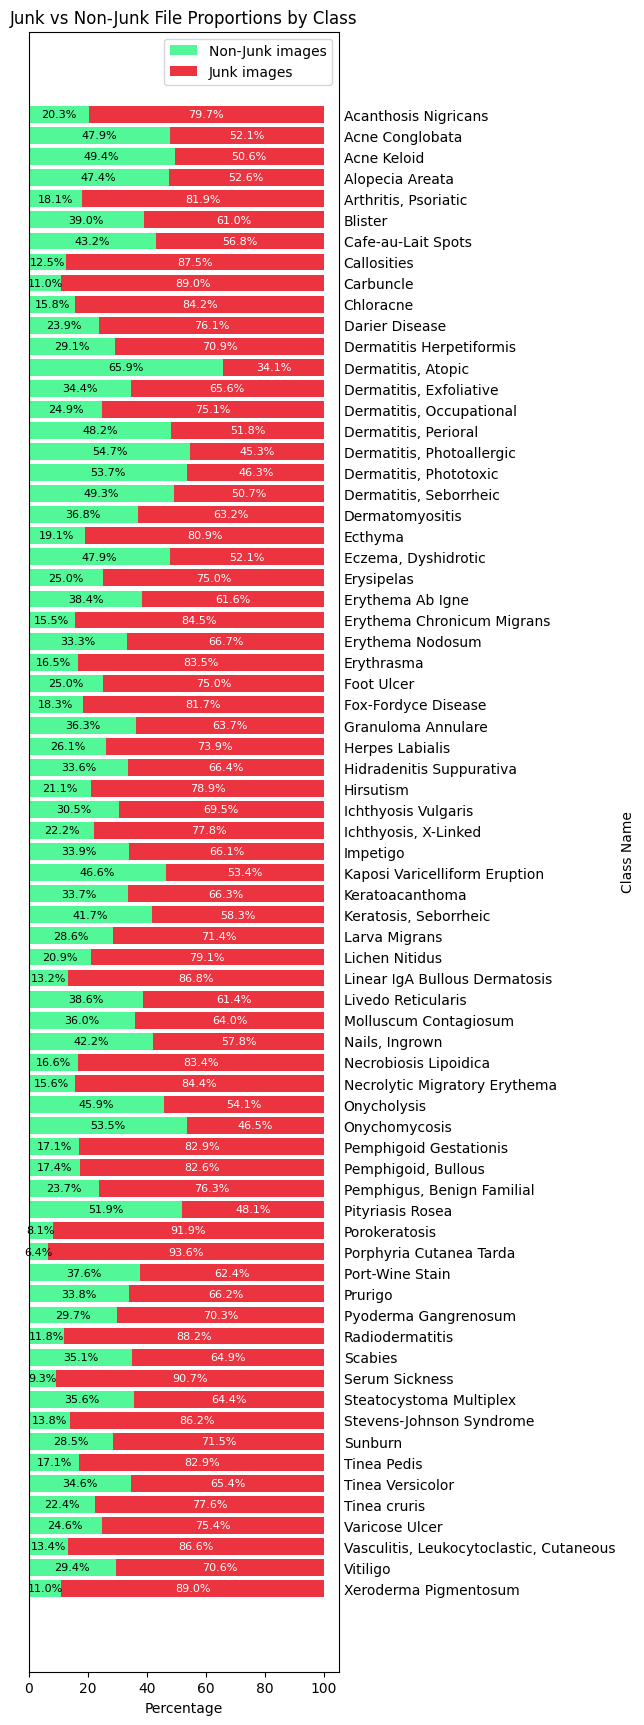

In [9]:
def plot_stacked_bar_chart(df):
    df = df.copy()
    df = df.sort_values('className', ascending=False)
    
    # Calculate % of junk and non-junk files
    df['nonJunkPercent'] = df['classCount'] / df['totalCount'] * 100
    df['junkPercent'] = df['junkCount'] / df['totalCount'] * 100
    height_per_class = 0.3
    total_classes = len(df['className'])
    fig_height = height_per_class * total_classes
    fig, ax = plt.subplots(figsize=(4, fig_height))

    # Add labels & title
    ax.set_title('Junk vs Non-Junk File Proportions by Class')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Class Name')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='y', length=0)

    # Plot non-junk images
    bars_non_junk = ax.barh(df['className'], df['nonJunkPercent'], color='#52f797', label='Non-Junk images')

    # Plot junk images
    bars_junk = ax.barh(df['className'], df['junkPercent'], color='#eb3440', left=df['nonJunkPercent'], label='Junk images')
    for bar in bars_non_junk:
        if bar.get_width() > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.1f}%", va='center', ha='center', color='black', fontsize=8)
    for bar in bars_junk:
        if bar.get_width() > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f"{bar.get_width():.1f}%", va='center', ha='center', color='white', fontsize=8)
    ax.legend()
    plt.show()

plot_stacked_bar_chart(df)

Compare proportion(%) of junk vs non-junk images across all classes